In [1]:
import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import sys
sys.path.append('../')

from Algorithms import incremental_greedy,no_step_greedy_ball
from utils import RandomUnifBall, verify_feasibility

from UpperBounds import reverse_upperbound_stepped,reverse_upperbound_no_step,relaxed_convex_upperbound

import RKHS
from RKHS import GPMI,Gram

import cvxpy as cp

import pickle as pkl
%load_ext autoreload
%autoreload 2

# Experiment parameters

In [2]:
T = 19

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radii = [0.6,1,1.5,3,5,10]
# search_region_radii = [1]
step_size = 1

x0 = search_region_center

# Callables

In [3]:

x_objective = partial(GPMI,c=c,l=l,var_0=var_0)

kernel = partial(RKHS.k,c=c,l=l)


# Different benchmark algorithms, call as needed.

In [4]:
seed = 0
np.random.seed(seed)

greedy_val = []

reverse_no_step = []

reverse_step = []

convex = []
T_max = 2*T
for search_region_radius in search_region_radii:
    print('Search Region Radius',search_region_radius)
    # The reference system.
    
    ref = np.array([[0,0]]) # A single point reference set.
    R = np.array([search_region_radius*np.ones(T_max)]).T


    N = len(ref)

    greedy = incremental_greedy(kernel,x0,step_size,ref,R,T_max,var_0,c)

    greedy_no_step = no_step_greedy_ball(kernel,x0,search_region_radius,T_max,var_0,c)

    rs = reverse_upperbound_stepped(x_objective,kernel,greedy,search_region_center,search_region_radius,c,var_0,step_size,T)

    rns = reverse_upperbound_no_step(x_objective,kernel,greedy_no_step,T)
    
    ref = np.array([[0,0]]) # A single point reference set.
    R = np.array([search_region_radius*np.ones(T)]).T

    cv = relaxed_convex_upperbound(step_size,c,l,var_0,kernel,ref,R,T,search_region_radius)
    
    greedy_val.append(x_objective(greedy[:T]))
    
    reverse_step.append(rs)
    
    reverse_no_step.append(rns[-1])
    
    convex.append(cv)

Search Region Radius 0.6
Search Region Radius 1
Search Region Radius 1.5
Search Region Radius 3
Search Region Radius 5
Search Region Radius 10


# Plotting

In [5]:
print(greedy_val,reverse_no_step,reverse_step,convex)

[1.7596206306114215e+01, 27.51131179766876, 35.795162314048746, 42.50567521977979, 42.51279470804582, 42.5294661463385] [24.228104810581858, 38.04309750121205, 43.843644909992015, 43.843644909992015, 43.843644909992015, 43.843644909992015] [21.218610632361965, 34.115334186961114, 43.67898178286861, 43.7718528854218, 43.77194712371736, 43.772006751135685] [38.007313600719485, 41.97102041831052, 42.59065128858849, 42.63381195158032, 42.63381117818076, 42.633810581172206]


In [15]:
results = {'Greedy Value':(greedy_val,None),
          'Convex Relaxation':(convex,'dashed'),
          'Reverse bound-no Step Constraint':(reverse_no_step,'dashed'),
          'Reverse bound-with Step Constraint':(reverse_step,'dashed')
          }

In [16]:
min_upperbound = np.min([convex,reverse_no_step,reverse_step],axis=0)

In [19]:
results['Min of upperbounds']=(min_upperbound,None)

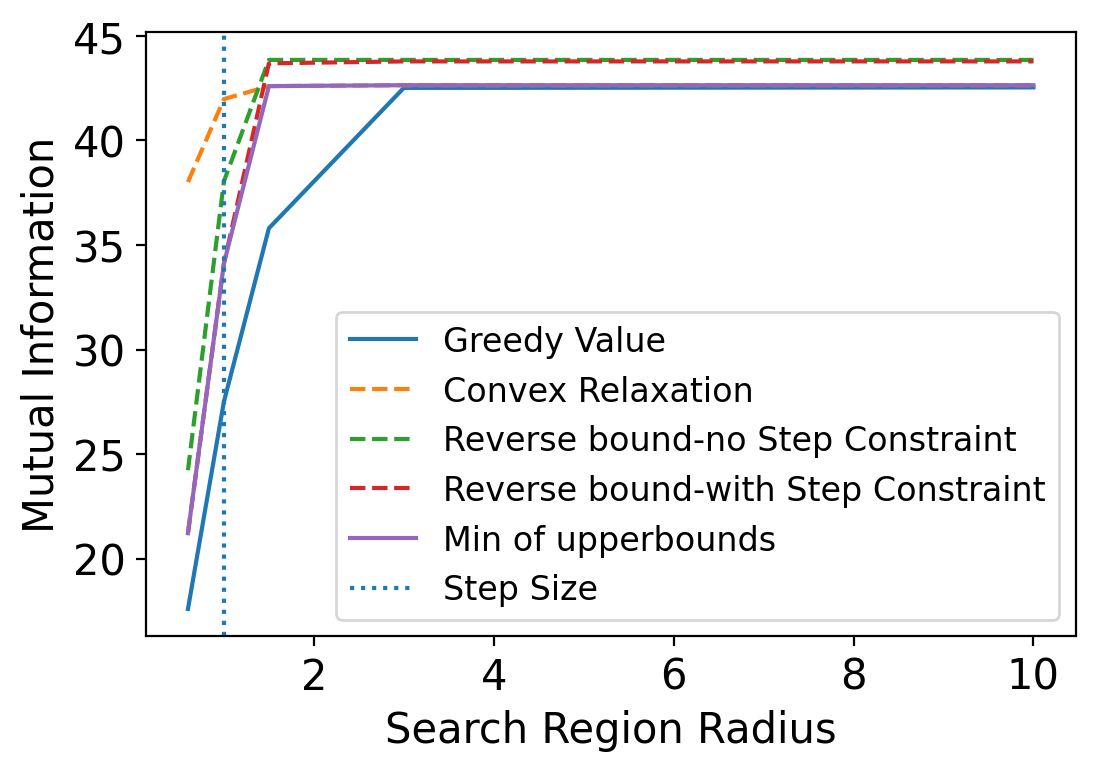

In [33]:
plt.figure(dpi=200)
plt.rc('font',size=15)
for key,val in results.items():
    plt.plot(search_region_radii,val[0],label = key,ls=val[1])
    plt.xlabel('Search Region Radius')
    plt.ylabel('Mutual Information')
    
plt.axvline(step_size,ls='dotted',label='Step Size')

plt.legend(prop={'size':12})
plt.show()

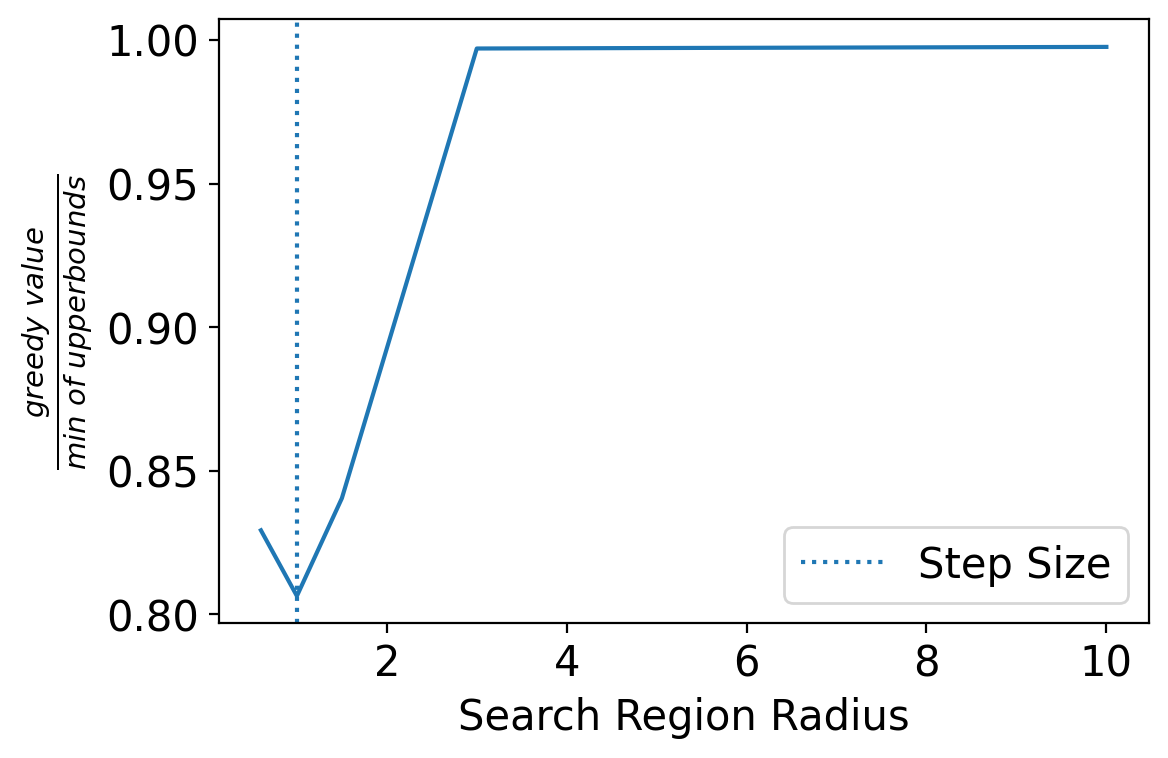

In [35]:
plt.figure(dpi=200)

plt.rc('font',size=15)
plt.plot(search_region_radii,greedy_val/min_upperbound)
plt.axvline(step_size,ls='dotted',label='Step Size')
plt.xlabel('Search Region Radius')
plt.ylabel(r'$\frac{greedy~value}{min~of~upperbounds}$')
plt.legend()